In [ ]:
# Stock market filtering signal decomposition
By Henry Chacon, henry.chacon@utsa.edu

Code developed to separate the Stock market series price by using the *empirical mode decomposition EMD* set of filters. **As input**, the daily price and volumen data is downloaded from Yahoo finances. Hence, the `ticker` entered should be the same used in that portal the request the information of any stock. **As output**, the forecast of each individual signal decomposition is forecasted using the LSTM model.

The following code is organized as follows:

1. A section with global variables definitions defined by the user to run the LSTM model
2. LSTM forecasting of the decomposed parts of the series
3. Forecast comparison

## Variables and functions definitions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import datetime
from datetime import date
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
# from keras.models import 
from tensorflow.keras import backend
from keras import losses
import csv, os, math, time
from sklearn.preprocessing import MinMaxScaler
from PyEMD import EMD, EEMD, CEEMDAN, Visualisation
from sampen import sampen2

Using TensorFlow backend.
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/.local/lib/python3.6/site-packages/tensorflow/python

In [2]:
# Forecasting error metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (100 * np.mean(np.abs((y_true - y_pred) / y_true)))

def weight_absolute_percentage_error(y_true, y_pred): 
    """Calculates WAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
    return (100 * np.sum(np.abs(y_true - y_pred)) / np.sum(y_true))


def directional_accuracy(y_true, y_pred): 
    """Calculates the directional accuracy metric"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (100 * np.sum((np.diff(y_true) * np.diff(y_pred)) >= 0) / (len(y_true) - 1))

def TheilsU(y_true, y_pred): 
    """Calculates the Theil's U predictor"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2)) / (np.sqrt(np.mean(y_true ** 2)) + np.sqrt(np.mean(y_pred ** 2)))

def average_relative_variance(y_true, y_pred): 
    """Calculates the ARV"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum((y_pred - y_true) ** 2) / np.sum((y_pred - np.mean(y_true)) ** 2)

# define a function to convert a vector of time series into a 2D matrix
def convertSeriesToMatrix(vectorSeries, sequence_length):
    matrix=[]
    for i in range(len(vectorSeries)-sequence_length+1):
        matrix.append(vectorSeries[i:i+sequence_length])
    return matrix

def signal_period(series, imf_id = 0):
    # Function to compute the period of the IMF sequence
    period = int(0.01 * len(series))
    length = []
    state = 0 if series[0] > 0 else 1   # 0 for negative and 1 for positive state. Initially inverse
    dst = 0
    for k in series:
        dst += 1
        ct_state = 1 if k > 0 else 0
        if ct_state != state:
            length.append(dst)
            state = ct_state
            dst = 0
    if (len(length) > 1):
#         kk = int(32 / (2 ** imf_id))
#         mlt =  kk if kk > 1 else 4
#         tmp = kk * int(np.round(np.mean(length[1:])))
        kk = 32 / (2 ** imf_id) 
#         kk = 1
        period = int(kk * np.round(np.mean(length[1:])))
        if period > 0.2*len(series):
            period = int(0.01 * len(series))
    return period

## Global variables to be defined before running the code

This is the only section recommended to be manipulated by the user

In [3]:
# Company ticker, initial period, final period
ticker = 'DIS'
start_day = datetime.datetime(2015, 1, 1)
# Filter selection, available options: EMD, EEMD, CEEMDAN
filter_name = 'EMD'
loss_MSE = True # If it is False, the mean_absolute_error will be selected
tanh_funct = False
metric = 'Adj Close' # available options: 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'
########
end_day = date.today()
EPOCHS = 150
# For alternative end date activate the follow row:
# end_day = datetime.datetime(2019, 10, 31)

## Series filter decomposition representation

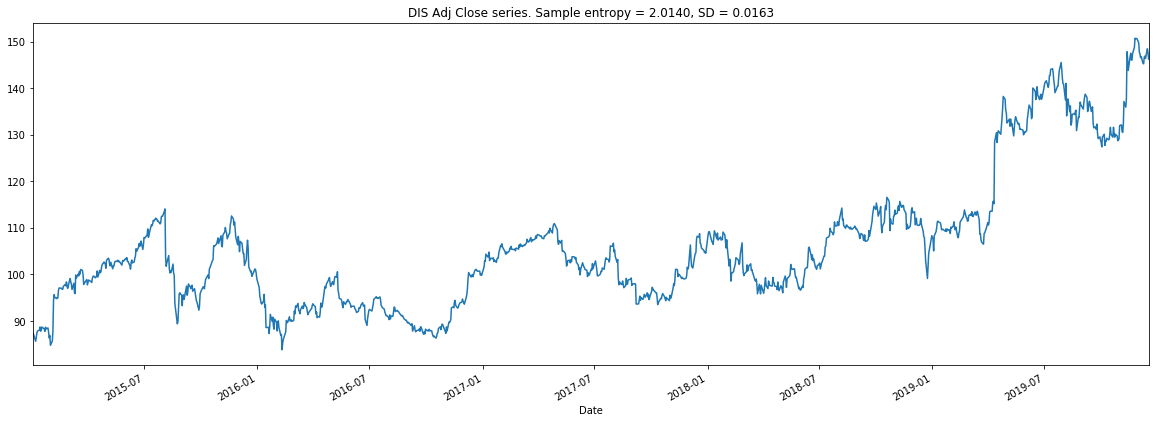

Sample entropy = 2.0140, SD = 0.0163
Number of IMFs: 8, ticker: DIS


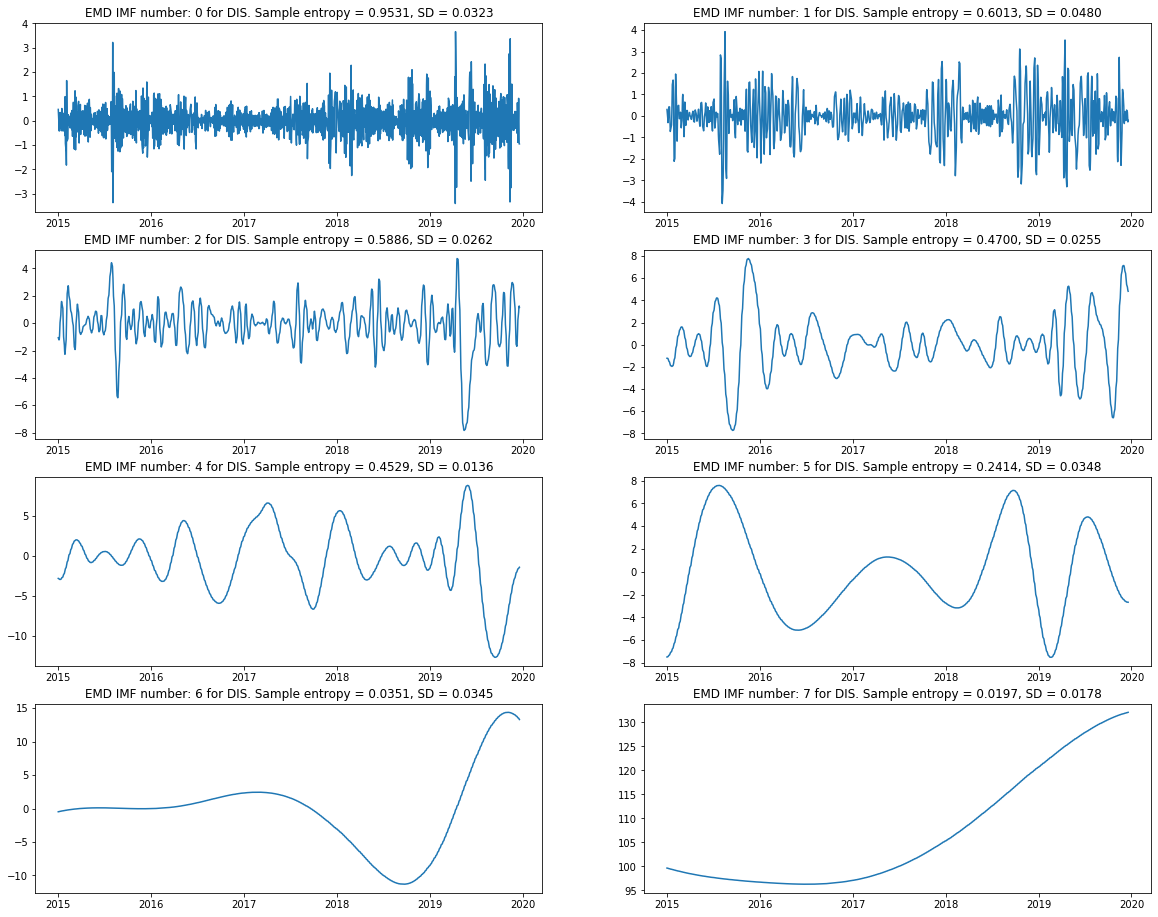

,Series,Intrinsic_entropy,SD
0,Adj Close,2.013989,0.016308
1,IMF 0,0.953138,0.032266
2,IMF 1,0.601332,0.048017
3,IMF 2,0.588586,0.026154
4,IMF 3,0.470029,0.025489
5,IMF 4,0.452872,0.013645
6,IMF 5,0.241399,0.034832
7,IMF 6,0.035050,0.034512
8,IMF 7,0.019702,0.017796


In [8]:
data = pdr.get_data_yahoo(ticker, start=start_day, end=end_day)
var_selection = '{}_norm'.format(metric)
data[var_selection] = (data[metric] - min(data[metric])) / (max(data[metric]) - min(data[metric]))
int_entropy = pd.DataFrame()
var_selection = metric

s_ent = sampen2(np.array(data[var_selection]))
fig = plt.figure(figsize=(20,7))
data[var_selection].plot()
plt.title('{} {} series. Sample entropy = {:.4f}, SD = {:.4f}'.format(ticker, var_selection, s_ent[-1][1], s_ent[-1][2]))
# fig.savefig(ticker'plot.png')
plt.savefig('./figures/' + filter_name + '_' + ticker + '_original.png')
plt.show()
print('Sample entropy = {:.4f}, SD = {:.4f}'.format(s_ent[-1][1], s_ent[-1][2]))
int_entropy = int_entropy.append(pd.DataFrame({'Series': var_selection, 'Intrinsic_entropy': s_ent[-1][1], 'SD': s_ent[-1][2]}, index = [0]))

if filter_name == 'EEMD': 
    emd = EMD()
elif filter_name == 'CEEMDAN':
    emd = CEEMDAN()
else:
    emd = EMD()
    
data_emd_full = emd(np.array(data[var_selection]))
IMF_num = data_emd_full.shape[0]
print('Number of IMFs: {}, ticker: {}'.format(IMF_num, ticker))
# int(np.ceil(IMF_num / 2))



fig = plt.figure(figsize=(20, 16))
for i in range(IMF_num):
    s_ent = sampen2(np.array(data_emd_full[i]))
    plt.subplot(4, 2, i+1)
    plt.plot(pd.DataFrame(data_emd_full[i], columns=['IMF {}'.format(i)], index=data.index))
    plt.title('{} IMF number: {} for {}. Sample entropy = {:.4f}, SD = {:.4f}'.format(filter_name, i, ticker, s_ent[-1][1], s_ent[-1][2]))
#     plt.savefig('./figures/' + filter_name + '_' + ticker + '_IMF_' + str(i) + '.png')
#     print('Sample entropy = {:.4f}, SD = {:.4f}'.format(s_ent[-1][1], s_ent[-1][2]))
    int_entropy = int_entropy.append(pd.DataFrame({'Series': 'IMF {}'.format(i), 'Intrinsic_entropy': s_ent[-1][1], 'SD': s_ent[-1][2]}, index = [i+1]))
plt.show()    
display(int_entropy)

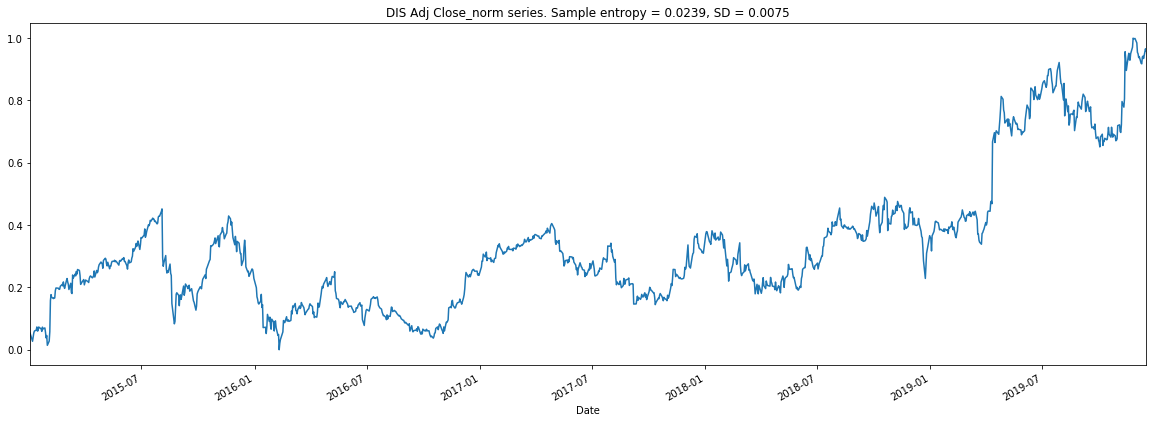

Sample entropy = 0.0239, SD = 0.0075
Number of IMFs: 8, ticker: DIS


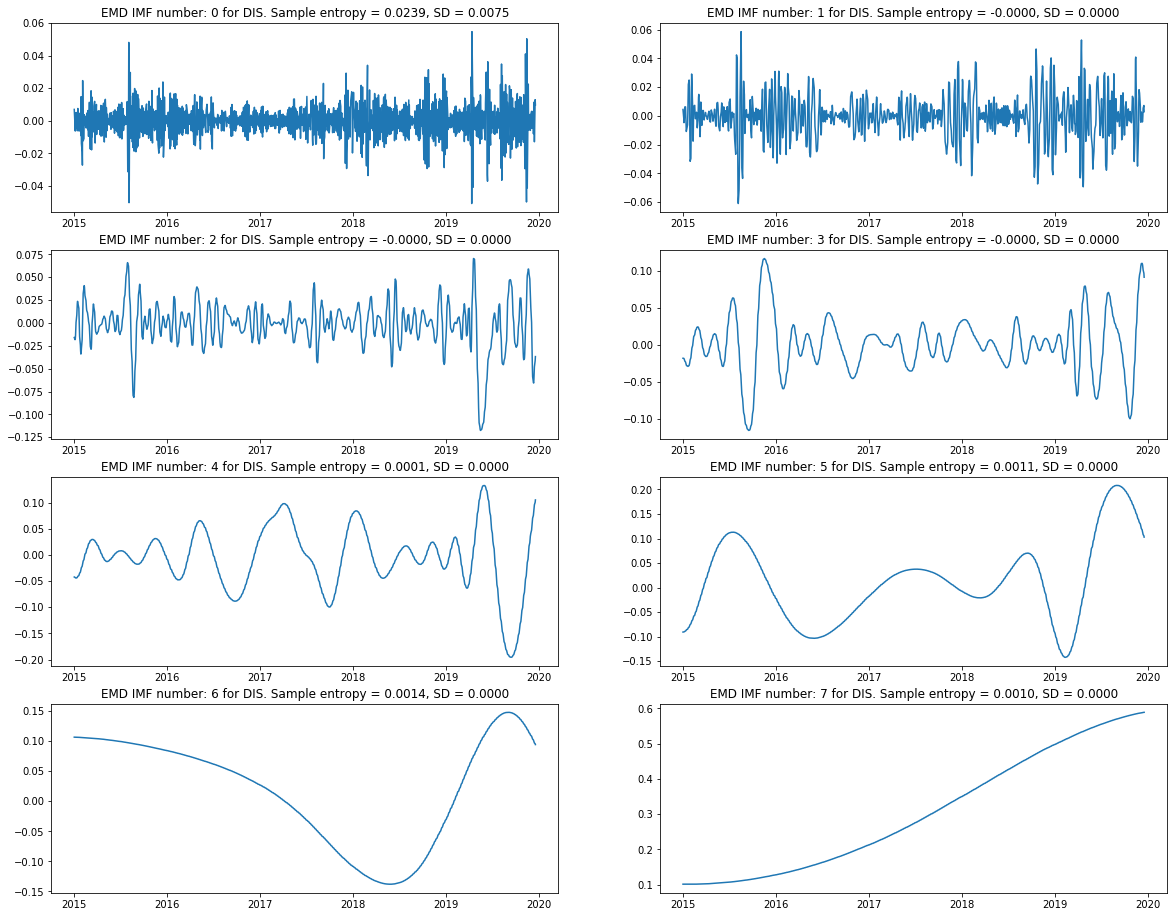

,Series,Intrinsic_entropy,SD
0,Adj Close_norm,0.023875,0.007485
1,IMF 0,-0.000000,0.000000
2,IMF 1,-0.000000,0.000000
3,IMF 2,-0.000000,0.000000
4,IMF 3,0.000135,0.000013
5,IMF 4,0.001122,0.000039
6,IMF 5,0.001410,0.000045
7,IMF 6,0.000960,0.000038
8,IMF 7,0.000756,0.000041


In [5]:
# data = pdr.get_data_yahoo(ticker, start=start_day, end=end_day)
var_selection = '{}_norm'.format(metric)
var_selection_norm = '{}_norm'.format(metric)

# data[var_selection] = (data[metric] - min(data[metric])) / (max(data[metric]) - min(data[metric]))
int_entropy = pd.DataFrame()

s_ent = sampen2(np.array(data[var_selection]))
fig = plt.figure(figsize=(20,7))
data[var_selection].plot()
plt.title('{} {} series. Sample entropy = {:.4f}, SD = {:.4f}'.format(ticker, var_selection, s_ent[-1][1], s_ent[-1][2]))
# fig.savefig(ticker'plot.png')
plt.savefig('./figures/' + filter_name + '_' + ticker + '_original.png')
plt.show()
print('Sample entropy = {:.4f}, SD = {:.4f}'.format(s_ent[-1][1], s_ent[-1][2]))
int_entropy = int_entropy.append(pd.DataFrame({'Series': var_selection, 'Intrinsic_entropy': s_ent[-1][1], 'SD': s_ent[-1][2]}, index = [0]))

if filter_name == 'EEMD': 
    emd = EMD()
elif filter_name == 'CEEMDAN':
    emd = CEEMDAN()
else:
    emd = EMD()
    
data_emd_norm = emd(np.array(data[var_selection]))
IMF_num = data_emd_norm.shape[0]
print('Number of IMFs: {}, ticker: {}'.format(IMF_num, ticker))
# int(np.ceil(IMF_num / 2))

fig = plt.figure(figsize=(20, 16))
for i in range(IMF_num):
    plt.subplot(4, 2, i+1)
    plt.plot(pd.DataFrame(data_emd_norm[i], columns=['IMF {}'.format(i)], index=data.index))
    plt.title('{} IMF number: {} for {}. Sample entropy = {:.4f}, SD = {:.4f}'.format(filter_name, i, ticker, s_ent[-1][1], s_ent[-1][2]))
#     plt.savefig('./figures/' + filter_name + '_' + ticker + '_IMF_' + str(i) + '.png')
    s_ent = sampen2(np.array(data_emd_norm[i]))
#     print('Sample entropy = {:.4f}, SD = {:.4f}'.format(s_ent[-1][1], s_ent[-1][2]))
    int_entropy = int_entropy.append(pd.DataFrame({'Series': 'IMF {}'.format(i), 'Intrinsic_entropy': s_ent[-1][1], 'SD': s_ent[-1][2]}, index = [i+1]))
plt.show()    
display(int_entropy)

# LSTM model for the original (normalized series)

In [6]:
# If you want to split the training set between 80 and 20 percent, use the following
train_row = int(np.round(len(data)*0.8))

# # If you want to separate it in X number of days for testing use the following line
X = 20
train_row = len(data) - X

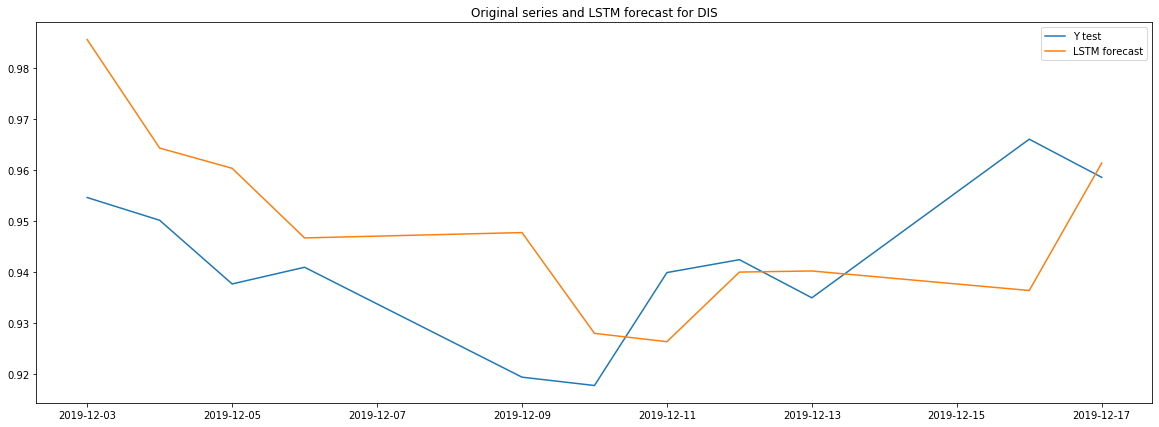

Original series forecast MAPE = 1.5984%, WAPE = 1.6000%, DA = 40.0000%, TheilsU = 0.0097, ARV = 1.0225, Window = 10


In [7]:
periods = 28
sequence_length = periods if (periods < (len(data) - train_row)) else int(np.round((len(data) - train_row) / 2))
units = 50

# LSTM model
# Sequence length is the window size for the LSTM model. Try with different sizes 
forecast_df = pd.DataFrame()
vector = data[var_selection].tolist()
# convert the vector to a 2D matrix
matrix = convertSeriesToMatrix(vector, sequence_length)
matrix = np.array(matrix)

# From the dimension of the matrix try different values 
# train_row = int(np.round(len(vector)*0.8))
train_set = matrix[:train_row,:]

# the training set
X_train = train_set[:, :-1]
# the last column is the true value to compute the mean-squared-error loss
y_train = train_set[:, -1]

# the test set
X_test = matrix[train_row:, :-1]
y_test = matrix[train_row:, -1]

# the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM
model = Sequential()
data_dim=1
timesteps= sequence_length - 1
# layer 1: LSTM
model.add(LSTM(units, return_sequences=True, input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 50
model.add(Dropout(0.2))
model.add(LSTM(units=units, return_sequences=False))
model.add(Dropout(0.2))
# layer 3: dense
if tanh_funct:
    model.add(Dense(units=1, activation='tanh'))
else:
    model.add(Dense(units=1, activation='linear'))
# compile the model
if loss_MSE:
#     model.compile(loss="mean_squared_error", optimizer="adam")
    model.compile(loss=losses.mean_squared_error, optimizer="RMSprop")
else:
    model.compile(loss=losses.mean_absolute_error, optimizer="sgd")

# Model weights
Wsave = model.get_weights()

model.set_weights(Wsave)
model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.05, verbose=0)

# get the predicted values
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))
mape = mean_absolute_percentage_error(y_test, np.squeeze(predicted_values))
wape = weight_absolute_percentage_error(y_test, np.squeeze(predicted_values))
dac = directional_accuracy(y_test, np.squeeze(predicted_values))
theilsu = TheilsU(y_test, np.squeeze(predicted_values))
arv = average_relative_variance(y_test, np.squeeze(predicted_values))
# s_ent = sampen2(np.array(y_test))

# results = results.append(pd.DataFrame({'Company': ticker, 'Filter': filter_name, 'Source': 'Original', 'Window': sequence_length, 'MAPE': mape, 'WAPE': wape, 'DA': dac, 'TheilsU': theilsu, 'ARV': arv, 'SamEnt': s_ent[-1][1], 'SamSD': s_ent[-1][2]}, index=[len(results)]))
forecast_comp = pd.DataFrame(list(zip(y_test, np.squeeze(predicted_values))), columns=['Y_test', 'LSTM predicted'], index=data.iloc[len(data)-len(X_test):, ].index)
fig = plt.figure(figsize=(20,7))
plt.plot(forecast_comp)
plt.title('Original series and LSTM forecast for {}'.format(ticker))
plt.legend(['Y test', 'LSTM forecast'], loc='best')
plt.savefig('./figures/' + filter_name + '_' + ticker + '_LSTM.png')
plt.show()
forecast_df['Series'] = forecast_comp['Y_test']
forecast_df['Forecast'] = forecast_comp['LSTM predicted']
print('Original series forecast MAPE = {:.4f}%, WAPE = {:.4f}%, DA = {:.4f}%, TheilsU = {:.4f}, ARV = {:.4f}, Window = {}'.format(mape, wape, dac, theilsu, arv, sequence_length))
# print('Original series forecast MAPE = {:.4f}%, WAPE = {:.4f}%, DA = {:.4f}%, TheilsU = {:.4f}, ARV = {:.4f}, SamEnt = {:.4f}({:.4f}), Window = {}'.format(mape, wape, dac, theilsu, arv, s_ent[-1][1], s_ent[-1][2], sequence_length))


# LSTM model for the series without selected IMF (filtered)

In [8]:
# This section covers the LSTM model forecast using the original series after removing the following IMF filters. They do not need to be in ascending or descending order
imf_remove = [0]

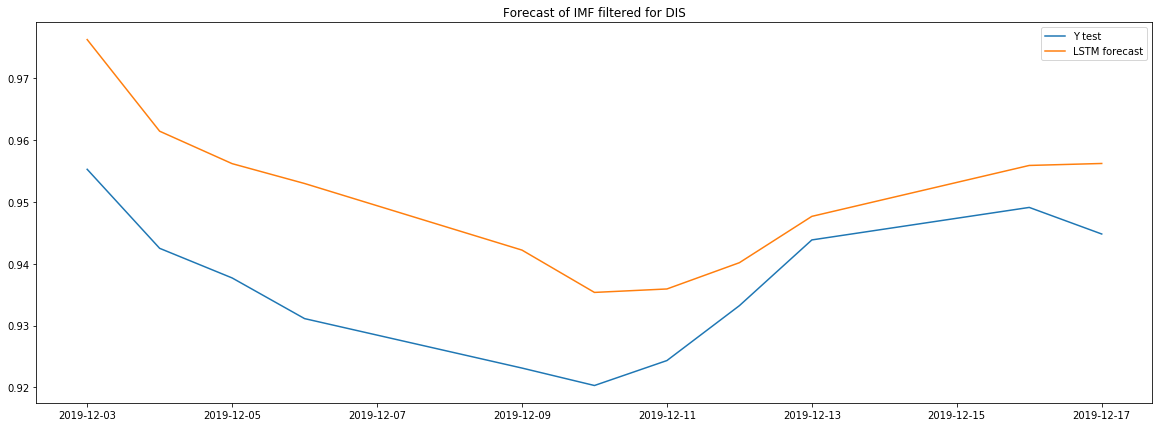

Original series forecast MAPE = 1.5028%, WAPE = 1.5016%, DA = 90.0000%, TheilsU = 0.0081, ARV = 0.7000, Window = 10


In [9]:
series = data[metric].copy()
for imf_num in imf_remove:
    series -= data_emd_full[imf_num]

var_selection = '{}_filtered'.format(metric)
data[var_selection] = series

var_selection = '{}_norm'.format(var_selection)
data[var_selection] = (series - min(series)) / (max(series) - min(series))

periods = 28
sequence_length = periods if (periods < (len(data) - train_row)) else int(np.round((len(data) - train_row) / 2))
units = 50

# LSTM model
# Sequence length is the window size for the LSTM model. Try with different sizes 
forecast_df = pd.DataFrame()
vector = data[var_selection].tolist()
# convert the vector to a 2D matrix
matrix = convertSeriesToMatrix(vector, sequence_length)
matrix = np.array(matrix)

# From the dimension of the matrix try different values 
# train_row = int(np.round(len(vector)*0.8))
train_set = matrix[:train_row,:]

# the training set
X_train = train_set[:, :-1]
# the last column is the true value to compute the mean-squared-error loss
y_train = train_set[:, -1]

# the test set
X_test = matrix[train_row:, :-1]
y_test = matrix[train_row:, -1]

# the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM
model = Sequential()
data_dim=1
timesteps= sequence_length - 1
# layer 1: LSTM
model.add(LSTM(units, return_sequences=True, input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 50
model.add(Dropout(0.2))
model.add(LSTM(units=units, return_sequences=False))
model.add(Dropout(0.2))
# layer 3: dense
if tanh_funct:
    model.add(Dense(units=1, activation='tanh'))
else:
    model.add(Dense(units=1, activation='linear'))
# compile the model
if loss_MSE:
#     model.compile(loss="mean_squared_error", optimizer="adam")
    model.compile(loss=losses.mean_squared_error, optimizer="RMSprop")
else:
    model.compile(loss=losses.mean_absolute_error, optimizer="sgd")

# Model weights
Wsave = model.get_weights()

model.set_weights(Wsave)
model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.05, verbose=0)

# get the predicted values
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))
mape = mean_absolute_percentage_error(y_test, np.squeeze(predicted_values))
wape = weight_absolute_percentage_error(y_test, np.squeeze(predicted_values))
dac = directional_accuracy(y_test, np.squeeze(predicted_values))
theilsu = TheilsU(y_test, np.squeeze(predicted_values))
arv = average_relative_variance(y_test, np.squeeze(predicted_values))
# s_ent = sampen2(np.array(y_test))

# results = results.append(pd.DataFrame({'Company': ticker, 'Filter': filter_name, 'Source': 'Original', 'Window': sequence_length, 'MAPE': mape, 'WAPE': wape, 'DA': dac, 'TheilsU': theilsu, 'ARV': arv, 'SamEnt': s_ent[-1][1], 'SamSD': s_ent[-1][2]}, index=[len(results)]))
forecast_comp = pd.DataFrame(list(zip(y_test, np.squeeze(predicted_values))), columns=['Y_test', 'LSTM predicted'], index=data.iloc[len(data)-len(X_test):, ].index)
fig = plt.figure(figsize=(20,7))
plt.plot(forecast_comp)
plt.title('Forecast of IMF filtered for {}'.format(ticker))
plt.legend(['Y test', 'LSTM forecast'], loc='best')
plt.savefig('./figures/' + filter_name + '_' + ticker + '_LSTM.png')
plt.show()
forecast_df['Series'] = forecast_comp['Y_test']
forecast_df['Forecast'] = forecast_comp['LSTM predicted']
# print('Original series forecast MAPE = {:.4f}%, WAPE = {:.4f}%, DA = {:.4f}%, TheilsU = {:.4f}, ARV = {:.4f}, SamEnt = {:.4f}({:.4f}), Window = {}'.format(mape, wape, dac, theilsu, arv, s_ent[-1][1], s_ent[-1][2], sequence_length))
print('Original series forecast MAPE = {:.4f}%, WAPE = {:.4f}%, DA = {:.4f}%, TheilsU = {:.4f}, ARV = {:.4f}, Window = {}'.format(mape, wape, dac, theilsu, arv, sequence_length))


# LSTM model for the series without selected IMF based on normalized input

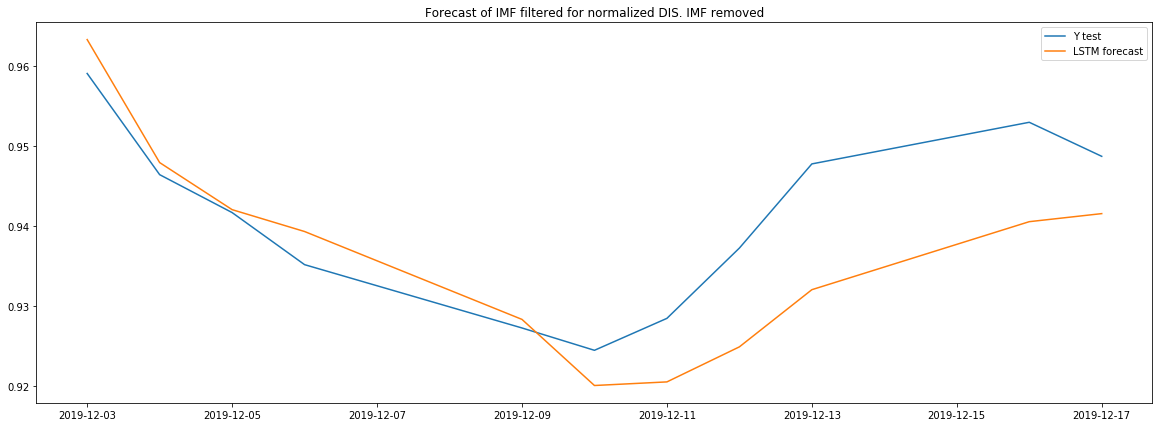

Original series forecast MAPE = 0.6890%, WAPE = 0.6904%, DA = 90.0000%, TheilsU = 0.0043, ARV = 0.3839, Window = 10


In [10]:
series = data[var_selection_norm].copy()
for imf_num in imf_remove:
    series -= data_emd_norm[imf_num]

var_selection = '{}_filtered'.format(var_selection_norm)
data[var_selection] = series

# var_selection = '{}_norm'.format(var_selection)
# data[var_selection] = (series - min(series)) / (max(series) - min(series))

periods = 28
sequence_length = periods if (periods < (len(data) - train_row)) else int(np.round((len(data) - train_row) / 2))
units = 50

# LSTM model
# Sequence length is the window size for the LSTM model. Try with different sizes 
forecast_df = pd.DataFrame()
vector = data[var_selection].tolist()
# convert the vector to a 2D matrix
matrix = convertSeriesToMatrix(vector, sequence_length)
matrix = np.array(matrix)

# From the dimension of the matrix try different values 
# train_row = int(np.round(len(vector)*0.8))
train_set = matrix[:train_row,:]

# the training set
X_train = train_set[:, :-1]
# the last column is the true value to compute the mean-squared-error loss
y_train = train_set[:, -1]

# the test set
X_test = matrix[train_row:, :-1]
y_test = matrix[train_row:, -1]

# the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM
model = Sequential()
data_dim=1
timesteps= sequence_length - 1
# layer 1: LSTM
model.add(LSTM(units, return_sequences=True, input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 50
model.add(Dropout(0.2))
model.add(LSTM(units=units, return_sequences=False))
model.add(Dropout(0.2))
# layer 3: dense
if tanh_funct:
    model.add(Dense(units=1, activation='tanh'))
else:
    model.add(Dense(units=1, activation='linear'))
# compile the model
if loss_MSE:
#     model.compile(loss="mean_squared_error", optimizer="adam")
    model.compile(loss=losses.mean_squared_error, optimizer="RMSprop")
else:
    model.compile(loss=losses.mean_absolute_error, optimizer="sgd")

# Model weights
Wsave = model.get_weights()

model.set_weights(Wsave)
model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.05, verbose=0)

# get the predicted values
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))
mape = mean_absolute_percentage_error(y_test, np.squeeze(predicted_values))
wape = weight_absolute_percentage_error(y_test, np.squeeze(predicted_values))
dac = directional_accuracy(y_test, np.squeeze(predicted_values))
theilsu = TheilsU(y_test, np.squeeze(predicted_values))
arv = average_relative_variance(y_test, np.squeeze(predicted_values))
# s_ent = sampen2(np.array(y_test))

# results = results.append(pd.DataFrame({'Company': ticker, 'Filter': filter_name, 'Source': 'Original', 'Window': sequence_length, 'MAPE': mape, 'WAPE': wape, 'DA': dac, 'TheilsU': theilsu, 'ARV': arv, 'SamEnt': s_ent[-1][1], 'SamSD': s_ent[-1][2]}, index=[len(results)]))
forecast_comp = pd.DataFrame(list(zip(y_test, np.squeeze(predicted_values))), columns=['Y_test', 'LSTM predicted'], index=data.iloc[len(data)-len(X_test):, ].index)
fig = plt.figure(figsize=(20,7))
plt.plot(forecast_comp)
plt.title('Forecast of IMF filtered for normalized {}. IMF removed'.format(ticker))
plt.legend(['Y test', 'LSTM forecast'], loc='best')
plt.savefig('./figures/' + filter_name + '_' + ticker + '_LSTM.png')
plt.show()
forecast_df['Series'] = forecast_comp['Y_test']
forecast_df['Forecast'] = forecast_comp['LSTM predicted']
# print('Original series forecast MAPE = {:.4f}%, WAPE = {:.4f}%, DA = {:.4f}%, TheilsU = {:.4f}, ARV = {:.4f}, SamEnt = {:.4f}({:.4f}), Window = {}'.format(mape, wape, dac, theilsu, arv, s_ent[-1][1], s_ent[-1][2], sequence_length))
print('Original series forecast MAPE = {:.4f}%, WAPE = {:.4f}%, DA = {:.4f}%, TheilsU = {:.4f}, ARV = {:.4f}, Window = {}'.format(mape, wape, dac, theilsu, arv, sequence_length))


# LSTM model for the series without selected IMF based on normalized input. After the series is filtered, it is normalized again

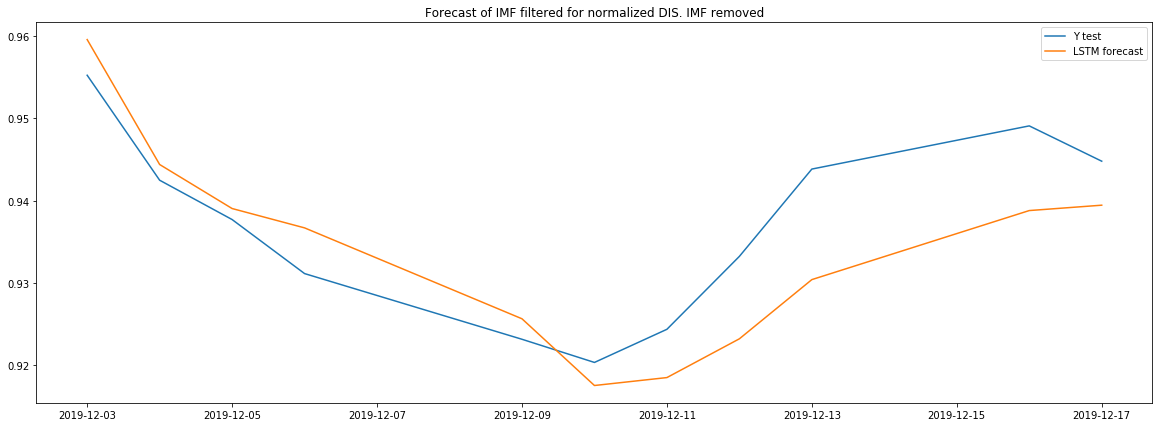

Original series forecast MAPE = 0.6142%, WAPE = 0.6155%, DA = 90.0000%, TheilsU = 0.0037, ARV = 0.3141, Window = 10


In [11]:
var_selection = '{}_norm'.format(var_selection)
data[var_selection] = (series - min(series)) / (max(series) - min(series))

periods = 28
sequence_length = periods if (periods < (len(data) - train_row)) else int(np.round((len(data) - train_row) / 2))
units = 50

# LSTM model
# Sequence length is the window size for the LSTM model. Try with different sizes 
forecast_df = pd.DataFrame()
vector = data[var_selection].tolist()
# convert the vector to a 2D matrix
matrix = convertSeriesToMatrix(vector, sequence_length)
matrix = np.array(matrix)

# From the dimension of the matrix try different values 
# train_row = int(np.round(len(vector)*0.8))
train_set = matrix[:train_row,:]

# the training set
X_train = train_set[:, :-1]
# the last column is the true value to compute the mean-squared-error loss
y_train = train_set[:, -1]

# the test set
X_test = matrix[train_row:, :-1]
y_test = matrix[train_row:, -1]

# the input to LSTM layer needs to have the shape of (number of samples, the dimension of each element)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM
model = Sequential()
data_dim=1
timesteps= sequence_length - 1
# layer 1: LSTM
model.add(LSTM(units, return_sequences=True, input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 50
model.add(Dropout(0.2))
model.add(LSTM(units=units, return_sequences=False))
model.add(Dropout(0.2))
# layer 3: dense
if tanh_funct:
    model.add(Dense(units=1, activation='tanh'))
else:
    model.add(Dense(units=1, activation='linear'))
# compile the model
if loss_MSE:
#     model.compile(loss="mean_squared_error", optimizer="adam")
    model.compile(loss=losses.mean_squared_error, optimizer="RMSprop")
else:
    model.compile(loss=losses.mean_absolute_error, optimizer="sgd")

# Model weights
Wsave = model.get_weights()

model.set_weights(Wsave)
model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.05, verbose=0)

# get the predicted values
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))
mape = mean_absolute_percentage_error(y_test, np.squeeze(predicted_values))
wape = weight_absolute_percentage_error(y_test, np.squeeze(predicted_values))
dac = directional_accuracy(y_test, np.squeeze(predicted_values))
theilsu = TheilsU(y_test, np.squeeze(predicted_values))
arv = average_relative_variance(y_test, np.squeeze(predicted_values))
# s_ent = sampen2(np.array(y_test))

# results = results.append(pd.DataFrame({'Company': ticker, 'Filter': filter_name, 'Source': 'Original', 'Window': sequence_length, 'MAPE': mape, 'WAPE': wape, 'DA': dac, 'TheilsU': theilsu, 'ARV': arv, 'SamEnt': s_ent[-1][1], 'SamSD': s_ent[-1][2]}, index=[len(results)]))
forecast_comp = pd.DataFrame(list(zip(y_test, np.squeeze(predicted_values))), columns=['Y_test', 'LSTM predicted'], index=data.iloc[len(data)-len(X_test):, ].index)
fig = plt.figure(figsize=(20,7))
plt.plot(forecast_comp)
plt.title('Forecast of IMF filtered for normalized {}. IMF removed'.format(ticker))
plt.legend(['Y test', 'LSTM forecast'], loc='best')
plt.savefig('./figures/' + filter_name + '_' + ticker + '_LSTM.png')
plt.show()
forecast_df['Series'] = forecast_comp['Y_test']
forecast_df['Forecast'] = forecast_comp['LSTM predicted']
# print('Original series forecast MAPE = {:.4f}%, WAPE = {:.4f}%, DA = {:.4f}%, TheilsU = {:.4f}, ARV = {:.4f}, SamEnt = {:.4f}({:.4f}), Window = {}'.format(mape, wape, dac, theilsu, arv, s_ent[-1][1], s_ent[-1][2], sequence_length))
print('Original series forecast MAPE = {:.4f}%, WAPE = {:.4f}%, DA = {:.4f}%, TheilsU = {:.4f}, ARV = {:.4f}, Window = {}'.format(mape, wape, dac, theilsu, arv, sequence_length))


In [12]:
data.head()

,High,Low,Open,Close,Volume,Adj Close,Adj Close_norm,Adj Close_filtered,Adj Close_filtered_norm,Adj Close_norm_filtered,Adj Close_norm_filtered_norm
Date,,,,,,,,,,,
2015-01-02,95.279999,92.849998,94.910004,93.750000,5865400.0,87.376266,0.053075,86.907213,0.035333,0.046065,0.035333
2015-01-05,93.349998,91.779999,93.279999,92.379997,7789400.0,86.099403,0.033992,86.290956,0.026054,0.036855,0.026054
2015-01-06,93.190002,91.160004,92.570000,91.889999,6793100.0,85.642708,0.027167,86.063289,0.022625,0.033452,0.022625
2015-01-07,93.150002,92.099998,92.720001,92.830002,6589500.0,86.518814,0.040260,86.389474,0.027537,0.038327,0.027537
2015-01-08,94.300003,93.559998,93.870003,93.790001,7579400.0,87.413536,0.053632,87.076755,0.037886,0.048599,0.037886


## Series decomposition representation after the series is filtered

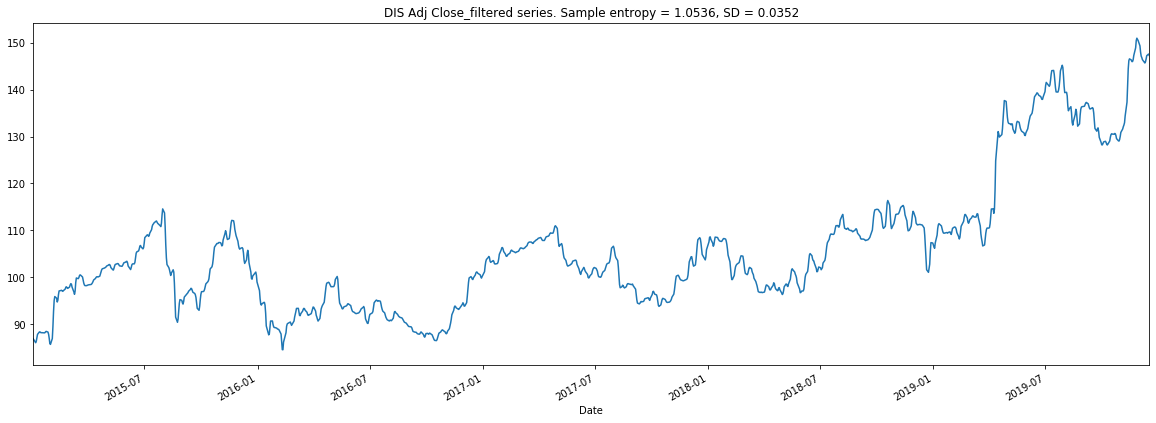

Sample entropy = 1.0536, SD = 0.0352
Number of IMFs: 7, ticker: DIS


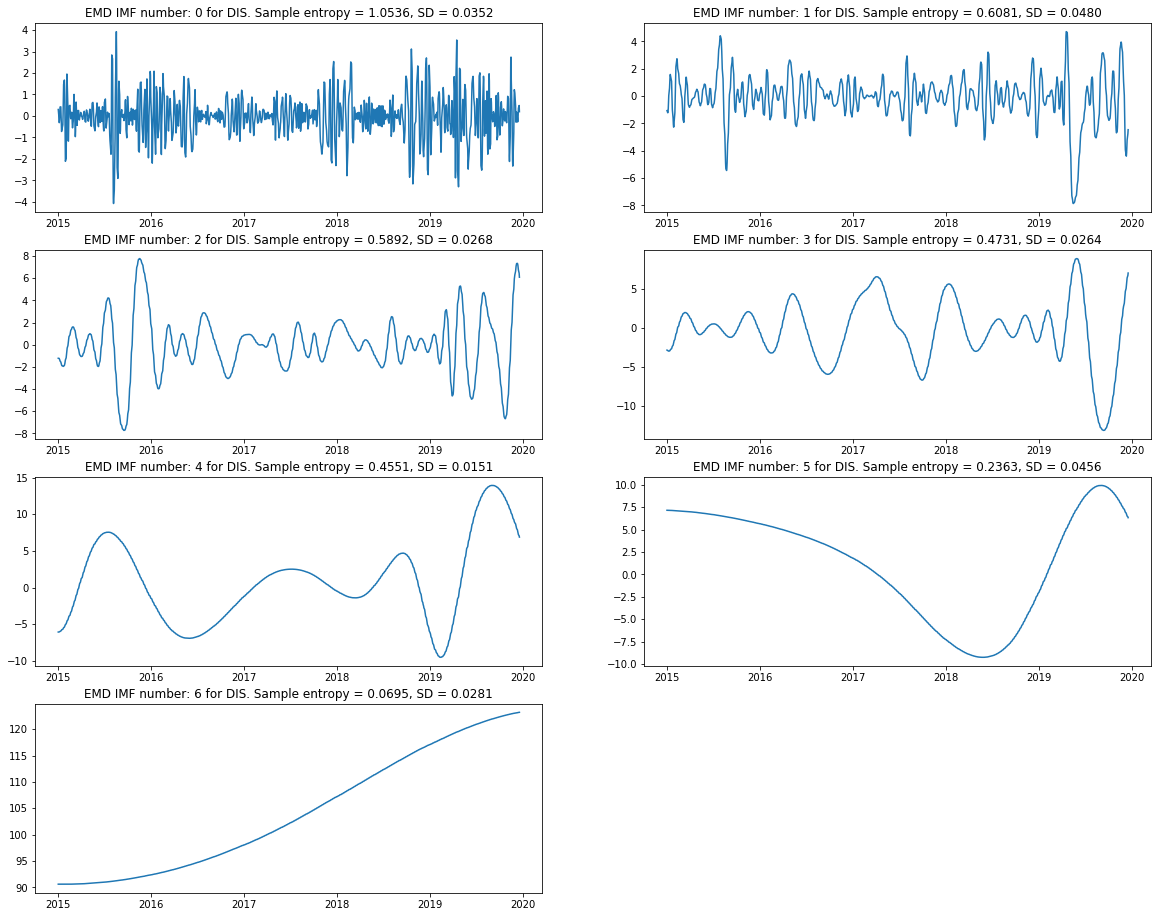

,Series,Intrinsic_entropy,SD
0,Adj Close_filtered,1.053649,0.035231
1,IMF 0,0.608057,0.048037
2,IMF 1,0.589165,0.026765
3,IMF 2,0.473105,0.026404
4,IMF 3,0.455105,0.015069
5,IMF 4,0.236276,0.045634
6,IMF 5,0.069490,0.028091
7,IMF 6,0.006057,0.000638


In [13]:
# data = pdr.get_data_yahoo(ticker, start=start_day, end=end_day)
var_selection = '{}_filtered'.format(metric)

# data[var_selection] = (data[metric] - min(data[metric])) / (max(data[metric]) - min(data[metric]))
int_entropy = pd.DataFrame()

s_ent = sampen2(np.array(data[var_selection]))
fig = plt.figure(figsize=(20,7))
data[var_selection].plot()
plt.title('{} {} series. Sample entropy = {:.4f}, SD = {:.4f}'.format(ticker, var_selection, s_ent[-1][1], s_ent[-1][2]))
# fig.savefig(ticker'plot.png')
plt.savefig('./figures/' + filter_name + '_' + ticker + '_original.png')
plt.show()
print('Sample entropy = {:.4f}, SD = {:.4f}'.format(s_ent[-1][1], s_ent[-1][2]))
int_entropy = int_entropy.append(pd.DataFrame({'Series': var_selection, 'Intrinsic_entropy': s_ent[-1][1], 'SD': s_ent[-1][2]}, index = [0]))

if filter_name == 'EEMD': 
    emd = EMD()
elif filter_name == 'CEEMDAN':
    emd = CEEMDAN()
else:
    emd = EMD()
    
data_emd_norm = emd(np.array(data[var_selection]))
IMF_num = data_emd_norm.shape[0]
print('Number of IMFs: {}, ticker: {}'.format(IMF_num, ticker))
# int(np.ceil(IMF_num / 2))

fig = plt.figure(figsize=(20, 16))
for i in range(IMF_num):
    plt.subplot(4, 2, i+1)
    plt.plot(pd.DataFrame(data_emd_norm[i], columns=['IMF {}'.format(i)], index=data.index))
    plt.title('{} IMF number: {} for {}. Sample entropy = {:.4f}, SD = {:.4f}'.format(filter_name, i, ticker, s_ent[-1][1], s_ent[-1][2]))
#     plt.savefig('./figures/' + filter_name + '_' + ticker + '_IMF_' + str(i) + '.png')
    s_ent = sampen2(np.array(data_emd_norm[i]))
#     print('Sample entropy = {:.4f}, SD = {:.4f}'.format(s_ent[-1][1], s_ent[-1][2]))
    int_entropy = int_entropy.append(pd.DataFrame({'Series': 'IMF {}'.format(i), 'Intrinsic_entropy': s_ent[-1][1], 'SD': s_ent[-1][2]}, index = [i+1]))
plt.show()    
display(int_entropy)